# **Step 1 : Data import and preparation**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, roc_curve, confusion_matrix, precision_score,
    recall_score, f1_score, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
)
from sklearn.utils import resample

from google.colab import files
Syllableerror_score = files.upload()
dict_Syllableerror_score = next(iter(Syllableerror_score))

df = pd.read_csv(dict_Syllableerror_score)
df = df.iloc[:,1:]
df = df.dropna()
df = df.reset_index(drop=True)

print(df)

Saving Syllableerror_score.csv to Syllableerror_score (5).csv
    disease  error_1  error_2  error_3  error_4
0         1        1        4        3        3
1         1        0        2        4        0
2         1        0        6        6        2
3         1        7        8        5       11
4         1        7        1        5        1
..      ...      ...      ...      ...      ...
69        0        0        1        1        1
70        0        0        0        2        1
71        0        0        0        3        2
72        0        0        0        3        1
73        0        1        0        2        1

[74 rows x 5 columns]


# **Step 2 : 5-Fold Cross-Validation, Model Evaluation, and ROC Curve Plotting**

In [ ]:
##### Define cross-validation, prepare hyperparameter and 95%CI calculation #####

# Define 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Hyperparameter grid for regularization strength (C)
C = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]
param_grid = {"C": C}

# Function to calculate 95% CI using bootstrap
def bootstrap_auc_ci(y_test, y_pred_proba, num_bootstrap=1000, alpha=0.95):
    bootstrapped_scores = []

    for _ in range(num_bootstrap):
        # Resample with replacement
        indices = resample(range(len(y_test)), replace=True)
        if len(np.unique(y_test.iloc[indices])) < 2:  # Ensure both classes exist
            continue
        auc = roc_auc_score(y_test.iloc[indices], y_pred_proba[indices])
        bootstrapped_scores.append(auc)

    # Compute percentiles for CI
    lower = np.percentile(bootstrapped_scores, (1 - alpha) / 2 * 100)
    upper = np.percentile(bootstrapped_scores, (alpha + (1 - alpha) / 2) * 100)

    return lower, upper



Processing feature: error_1
L1 Regularization Best Params: {'C': 10}
L1 Regularization Best Score: 0.7254545454545456
L2 Regularization Best Params: {'C': 1}
L2 Regularization Best Score: 0.7254545454545456
Accuracy: 0.70
Precision: 0.78
Recall (Sensitivity): 0.58
Specificity: 0.82
F1-Score: 0.67
AUC Score: 0.86
95% CI: (0.68, 0.98)
------------------------------------------------------------

Processing feature: error_2
L1 Regularization Best Params: {'C': 0.1}
L1 Regularization Best Score: 0.8400000000000001
L2 Regularization Best Params: {'C': 0.1}
L2 Regularization Best Score: 0.8400000000000001
Accuracy: 0.78
Precision: 0.71
Recall (Sensitivity): 1.00
Specificity: 0.55
F1-Score: 0.83
AUC Score: 0.86
95% CI: (0.67, 0.98)
------------------------------------------------------------

Processing feature: error_3
L1 Regularization Best Params: {'C': 10}
L1 Regularization Best Score: 0.5509090909090909
L2 Regularization Best Params: {'C': 1}
L2 Regularization Best Score: 0.630909090909

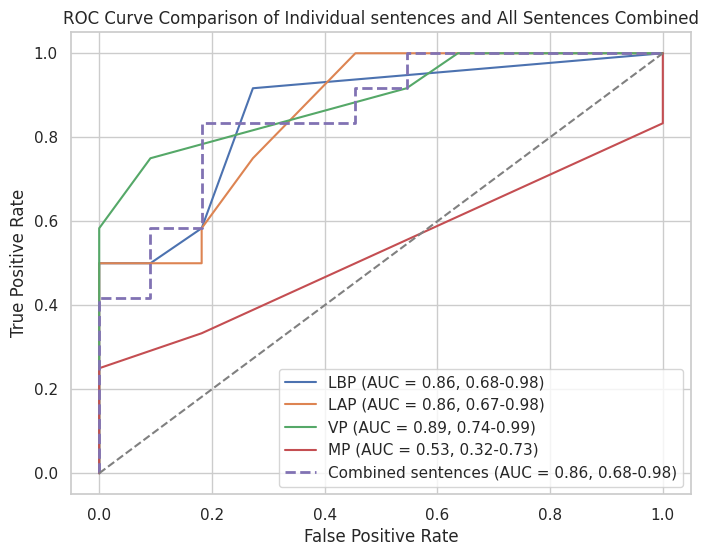

In [ ]:
##### Dataset preparation #####

# Load your dataset (assuming df is predefined)
data = df
domain = 'disease'  #'Target variable'
features = ['error_1', 'error_2', 'error_3', 'error_4']  #'Features'
features_label = ['LBP', 'LAP', 'VP', 'MP'] #as abbv. of Labial-Placement, Lingual-Alveolar-Placement, Velo-Pharyngeal-Placement, and Mixed-Placement, respectively

# Prepare dataset
data_final = data[features + [domain]].dropna().reset_index(drop=True)

# Define target variable(y)
y = data_final[domain]

# Initialize ROC plot
plt.figure(figsize=(8, 6))
plt.rc("font", size=14)
sns.set(style="whitegrid")


##### Loop through each feature(each sentence) individually #####
for i, feature in enumerate(features):
  print(f"\nProcessing feature: {feature}")

  # Use only the current feature
  X = data_final[[feature]]

  # Train-test split (70-30 stratified)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17, stratify=y)

  # Standardize features
  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)

  # Grid Search with 5-Fold Cross-Validation
  lr_L1 = LogisticRegression(max_iter=100, solver='liblinear', penalty='l1')
  lr_L2 = LogisticRegression(max_iter=100)  # Default is L2 penalty

  search_cv_1 = GridSearchCV(lr_L1, param_grid, cv=kf, scoring='accuracy')
  search_cv_2 = GridSearchCV(lr_L2, param_grid, cv=kf, scoring='accuracy')

  search_cv_1.fit(X_train_scaled, y_train)
  search_cv_2.fit(X_train_scaled, y_train)

  # Best hyperparameters and cross-validation scores
  print('L1 Regularization Best Params:', search_cv_1.best_params_)
  print('L1 Regularization Best Score:', search_cv_1.best_score_)

  print('L2 Regularization Best Params:', search_cv_2.best_params_)
  print('L2 Regularization Best Score:', search_cv_2.best_score_)

  # Choose best model based on validation score
  best_model = search_cv_1.best_estimator_ if search_cv_1.best_score_ > search_cv_2.best_score_ else search_cv_2.best_estimator_

  # Predictions
  y_pred = best_model.predict(X_test_scaled)
  y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]

  # Compute Confusion Matrix
  tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

  # Compute Metrics
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)  # Sensitivity (True Positive Rate)
  specificity = tn / (tn + fp)  # True Negative Rate
  f1 = f1_score(y_test, y_pred)
  auc_score = roc_auc_score(y_test, y_pred_proba)
  ci_lower, ci_upper = bootstrap_auc_ci(y_test, y_pred_proba)

  # Print Evaluation Metrics
  print(f"Accuracy: {accuracy:.2f}")
  print(f"Precision: {precision:.2f}")
  print(f"Recall (Sensitivity): {recall:.2f}")
  print(f"Specificity: {specificity:.2f}")
  print(f"F1-Score: {f1:.2f}")
  print(f"AUC Score: {auc_score:.2f}")
  print(f"95% CI: ({ci_lower:.2f}, {ci_upper:.2f})")
  print("-" * 60)

  # Compute ROC Curve
  fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

  # Compute Youden's Index and find optimal threshold
  youden_index = tpr - fpr
  optimal_idx = np.argmax(youden_index)
  optimal_threshold = thresholds[optimal_idx]

  # Plot ROC Curve
  plt.plot(fpr, tpr, label=f"{features_label[i]} (AUC = {auc_score:.2f}, {ci_lower:.2f}-{ci_upper:.2f})")


##### Now, train a logistic regression model using all four features combined (named as 'Combined sentences') #####
print("\nProcessing all features together('Combined sentences')")
X_all = data_final[features]

# Train-test split (70-30 stratified)
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y, test_size=0.3, random_state=17, stratify=y)

# Standardize features
scaler_all = StandardScaler()
X_train_all_scaled = scaler_all.fit_transform(X_train_all)
X_test_all_scaled = scaler_all.transform(X_test_all)

# Grid Search with 5-Fold Cross-Validation
lr_L1_all = LogisticRegression(max_iter=100, solver='liblinear', penalty='l1')
lr_L2_all = LogisticRegression(max_iter=100)  # Default is L2 penalty

search_cv_1_all = GridSearchCV(lr_L1_all, param_grid, cv=kf, scoring='accuracy')
search_cv_2_all = GridSearchCV(lr_L2_all, param_grid, cv=kf, scoring='accuracy')

search_cv_1_all.fit(X_train_all_scaled, y_train_all)
search_cv_2_all.fit(X_train_all_scaled, y_train_all)

# Best hyperparameters and cross-validation scores
print('L1 Regularization Best Params:', search_cv_1_all.best_params_)
print('L1 Regularization Best Score:', search_cv_1_all.best_score_)

print('L2 Regularization Best Params:', search_cv_2_all.best_params_)
print('L2 Regularization Best Score:', search_cv_2_all.best_score_)

# Choose best model based on validation score
best_model_all = search_cv_1_all.best_estimator_ if search_cv_1_all.best_score_ > search_cv_2_all.best_score_ else search_cv_2_all.best_estimator_

# Predictions
y_pred_all = best_model_all.predict(X_test_all_scaled)
y_pred_proba_all = best_model_all.predict_proba(X_test_all_scaled)[:, 1]

# Compute Confusion Matrix
tn_all, fp_all, fn_all, tp_all = confusion_matrix(y_test_all, y_pred_all).ravel()

# Compute Metrics
accuracy_all = accuracy_score(y_test_all, y_pred_all)
precision_all = precision_score(y_test_all, y_pred_all)
recall_all = recall_score(y_test_all, y_pred_all)  # Sensitivity (True Positive Rate)
specificity_all = tn_all / (tn_all + fp_all)  # True Negative Rate
f1_all = f1_score(y_test_all, y_pred_all)
auc_score_all = roc_auc_score(y_test_all, y_pred_proba_all)
ci_lower_all, ci_upper_all = bootstrap_auc_ci(y_test_all, y_pred_proba_all)

# Print Evaluation Metrics
print(f"Accuracy: {accuracy_all:.2f}")
print(f"Precision: {precision_all:.2f}")
print(f"Recall (Sensitivity): {recall_all:.2f}")
print(f"Specificity: {specificity_all:.2f}")
print(f"F1-Score: {f1_all:.2f}")
print(f"AUC Score: {auc_score_all:.2f}")
print(f"95% CI: ({ci_lower_all:.2f}, {ci_upper_all:.2f})")

print("=" * 60)

# Compute ROC Curve for all features ('Combined sentences')
fpr_all, tpr_all, thresholds_all = roc_curve(y_test_all, y_pred_proba_all)

# Compute Youden's Index for all features ('Combined sentences') and find optimal threshold
youden_index_all = tpr_all - fpr_all
optimal_idx_all = np.argmax(youden_index_all)
optimal_threshold_all = thresholds_all[optimal_idx_all]

# Plot ROC Curve for all features ('Combined sentences')
plt.plot(fpr_all, tpr_all, label=f"Combined sentences (AUC = {auc_score_all:.2f}, {ci_lower_all:.2f}-{ci_upper_all:.2f})", linestyle='--', linewidth=2)

# Plot settings
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison of Individual sentences and All Sentences Combined")
plt.legend()
plt.show()


Processing feature: error_1
L1 Regularization Best Params: {'C': 10}
L1 Regularization Best Score: 0.7254545454545456
L2 Regularization Best Params: {'C': 1}
L2 Regularization Best Score: 0.7254545454545456
Accuracy: 0.70
Precision: 0.78
Recall (Sensitivity): 0.58
Specificity: 0.82
F1-Score: 0.67
AUC Score: 0.86
95% CI: (0.69, 0.98)
------------------------------------------------------------

Processing feature: error_2
L1 Regularization Best Params: {'C': 0.1}
L1 Regularization Best Score: 0.8400000000000001
L2 Regularization Best Params: {'C': 0.1}
L2 Regularization Best Score: 0.8400000000000001
Accuracy: 0.78
Precision: 0.71
Recall (Sensitivity): 1.00
Specificity: 0.55
F1-Score: 0.83
AUC Score: 0.86
95% CI: (0.68, 0.98)
------------------------------------------------------------

Processing feature: error_3
L1 Regularization Best Params: {'C': 10}
L1 Regularization Best Score: 0.5509090909090909
L2 Regularization Best Params: {'C': 1}
L2 Regularization Best Score: 0.630909090909

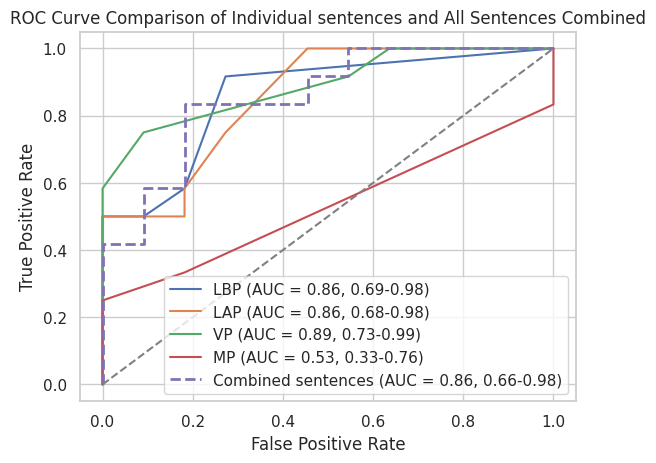